# Determinants of Mortgage Interest Rates: An Econometric Analysis Using Freddie Mac Loan Data

#### Introduction

The objective of this project is to examine the factors that influence mortgage interest rates across borrowers in the United States. Using econometric methods, we aim to identify how borrower characteristics and loan attributes contribute to variations in interest rates, with particular attention to financial risk indicators such as debt levels, collateral value, and loan size. The dataset used in this analysis originates from Freddie Mac, a government-sponsored enterprise that plays a central role in the U.S. housing finance system. The data includes detailed loan-level information from mortgage originations in 2011, providing a rich cross-section of borrower and loan characteristics.

Key variables used in this project include:

DTI (Debt-to-Income Ratio): This represents the ratio of a borrower’s total monthly debt payments to their gross monthly income. A higher DTI indicates greater financial strain and potentially higher risk for lenders.
    
UPB (Unpaid Principal Balance): This is the remaining amount of principal that the borrower still owes on the loan, typically measured in thousands of dollars. It reflects the size of the loan and may influence pricing through credit risk exposure.

LTV (Loan-to-Value Ratio): Calculated as the loan amount divided by the appraised value of the property, LTV indicates the level of equity the borrower has in the home. Higher LTV ratios imply greater risk for lenders, as the borrower has less at stake in the event of default.

Through regression analysis, including fixed effects and transformations, this study seeks to uncover how these variables and others impact mortgage interest rates and assess their statistical and practical significance.


#### Data Filtering 

In [1]:
#Importing relavant modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy.stats import chi2
from linearmodels.panel import PanelOLS
import linearmodels as lm


In [2]:
import pandas as pd

#Using Relevant Data Categories 
var_names= ["Credit_Score","First_Payment_date","First_Time_Homebuyer", "Maturity_Date",
"MSA","Mortgage_Insurance_Percentage","Number_Units","Occupancy_Status","CLTV",
"DTI","UPB","LTV","Interest_Rate","Channel","Prepayment_Penalty",
"Amortization_Type","State","Property_Type","Postal_Code","Sequence_Number",
"Purpose","Loan_Term","Number_Borrowers","Seller_Name","Servicer_Name",
"Super_Conforming","Pre-HARP_Loan","Program_Indicator","HARP_Indicator",
"Valuation_Method","Interest_Only", "Insurance_cancellation"]

na = {"DTI":[999], "LTV":[999], "Credit_Score":[9999]}
data1 = pd.read_csv("sample_orig_2011.txt", sep="|", names=var_names, na_values=na)

#UPB is denoted in thousands
data1["UPB_Thousands"] = data1["UPB"] / 1000

In [3]:
print(data1.head())

   Credit_Score  First_Payment_date First_Time_Homebuyer  Maturity_Date  \
0         770.0              201103                    N         202602   
1         684.0              201103                    N         204102   
2         777.0              201103                    N         204102   
3         798.0              201103                    N         204102   
4         809.0              201103                    N         204102   

       MSA  Mortgage_Insurance_Percentage  Number_Units Occupancy_Status  \
0      NaN                              0             1                P   
1  19380.0                              0             1                P   
2  26180.0                              0             2                I   
3  37860.0                              0             1                P   
4  16974.0                              0             3                P   

   CLTV   DTI  ...    Seller_Name    Servicer_Name  Super_Conforming  \
0    75  37.0  ...  

#### 1. Finding Relationships To Interest Rate Through Visualization

We want to see if we can find a clear relationship or correlation between the regressors and regressed -- Interest Rates 

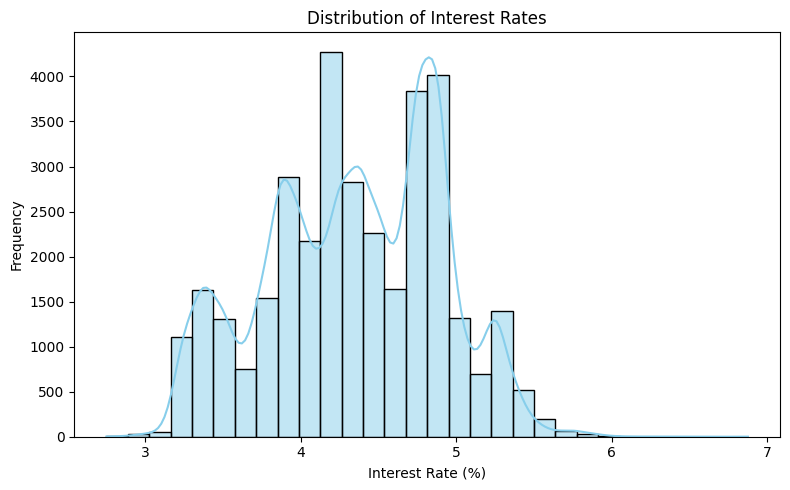

In [4]:
df_copy = data1.copy()

#plot
plt.figure(figsize=(8, 5))
sns.histplot(data=data1, x='Interest_Rate', bins=30, color='skyblue', kde=True)
plt.title('Distribution of Interest Rates')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The histogram of interest rates reveals that most mortgage loans in the dataset have interest rates concentrated between 4.0% and 5.0%, with a clear peak just below 4.5%, indicating this was the most common rate offered at the time. The distribution is slightly right-skewed, suggesting that while most borrowers received relatively moderate rates, there is a small portion who paid significantly higher rates—possibly due to risk factors or loan product types. The shape of the distribution, with multiple smaller peaks, hints at the presence of distinct borrower segments or mortgage products, such as fixed versus adjustable-rate loans. Interest rates range approximately from 2.75% to 6.75%, reflecting variability in loan terms, borrower credit quality, and market conditions. Overall, this distribution suggests a dominant cluster of prime borrowers receiving favorable rates, with a smaller spread of outliers potentially driven by higher-risk lending or specialized loan programs. We will see if the selected variables have relationships with regressor variables. 

/var/folders/2h/bd9j7tkj5wz80c9dzwy4ltx40000gn/T/ipykernel_18438/2673413429.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_copy.groupby('Loan_Term_Binned').agg(


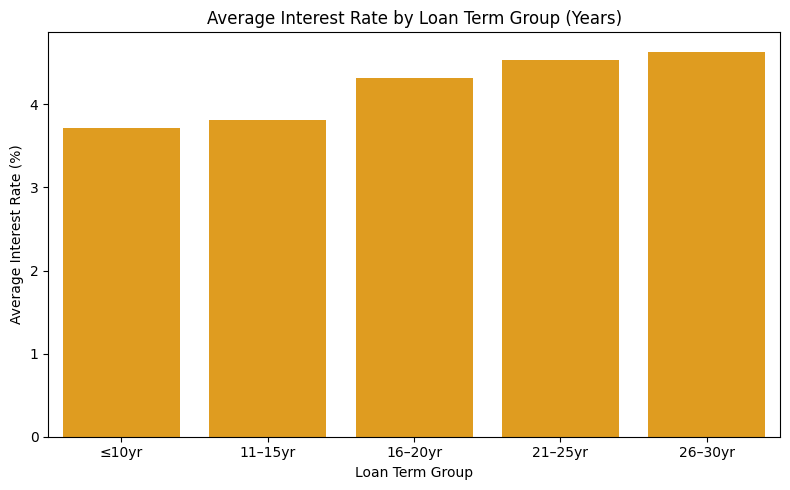

In [5]:
# Convert loan term from months to years

df_copy = df_copy.copy()
df_copy['Loan_Term_Years'] = df_copy['Loan_Term'] / 12

# Define bins
bins = [0, 10, 15, 20, 25, 30]
labels = ['≤10yr', '11–15yr', '16–20yr', '21–25yr', '26–30yr']

# Apply binning to the new column
df_copy['Loan_Term_Binned'] = pd.cut(df_copy['Loan_Term_Years'], bins=bins, labels=labels, right=True, include_lowest=True)

# Caculate average interest rate
summary = df_copy.groupby('Loan_Term_Binned').agg(
    avg_interest_rate=('Interest_Rate', 'mean')
).reset_index()

# Present the graph
plt.figure(figsize=(8, 5))
sns.barplot(x='Loan_Term_Binned', y='avg_interest_rate', data=summary, color='orange')
plt.title('Average Interest Rate by Loan Term Group (Years)')
plt.xlabel('Loan Term Group')
plt.ylabel('Average Interest Rate (%)')
plt.tight_layout()
plt.show()


The bar plot shows a clear, upward trend in average interest rates as loan terms increase. Borrowers with shorter-term loans (≤10 years and 11–15 years) have lower average interest rates, while those with longer-term loans (21–30 years) face progressively higher rates. This pattern is expected because longer loan terms carry greater risk for lenders—due to more uncertainty over time, higher exposure to interest rate changes, and a longer period to recover the loan. As a result, lenders typically charge higher interest rates to compensate for this increased risk and time horizon.

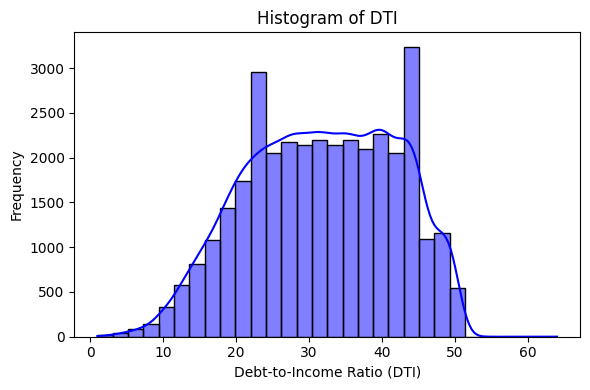

In [6]:
#plot
plt.figure(figsize=(6, 4))
sns.histplot(data1["DTI"], bins=30, kde=True, color='blue')
plt.xlabel("Debt-to-Income Ratio (DTI)")
plt.ylabel("Frequency")
plt.title("Histogram of DTI")
plt.tight_layout()
plt.show()

The graphs demonstrate the DTI distribution of the data set. DTI is the dedit to income ratio.$ DTI is a financial metric used to evaluate a borrower's ability to pay back monthly debt payments relative to their income. The distribution is roughly normal, slightly left-skewed. While most values fall between 10% and 50%, there are clear spikes at ~25% and ~45%. The spike of around 25% reflects that many banks prefer borrowers with low risk. In addition, the spike of around 45% is often the maximum limit that banks allow. There are very few people whose DTI is higher than 50% which indicates that banks usually do not approve loans for people who spend more than half of their income on debt. In conclusion, the graph shows that most borrowers are financially stable and the two spikes reflect the loan approval rules and safety limits

A higher DTI ratio typically indicates greater financial strain on the borrower (i.e., more of their income is used to pay off debt). Lenders generally view this as higher risk, which may result in higher interest rates. The spike at DTI 45 may correspond to tighter lending standards, which could result in either very high or very low interest rates, depending on how risk is priced for these borrowers. The shape does suggest a clear relationship to interest rates.

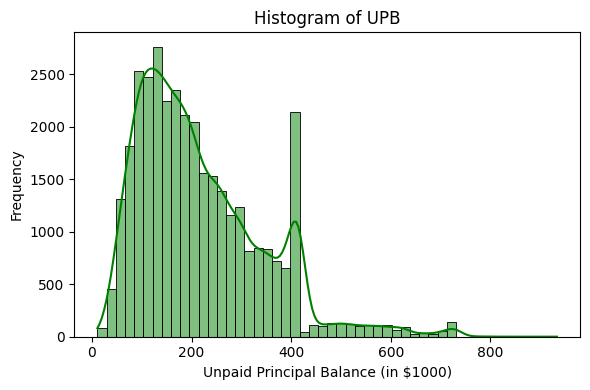

In [7]:
#plot
plt.figure(figsize=(6, 4))
sns.histplot(data1["UPB_Thousands"], bins=50, kde=True, color='green')
plt.xlabel("Unpaid Principal Balance (in $1000)")
plt.ylabel("Frequency")
plt.title("Histogram of UPB")
plt.tight_layout()
plt.show()

The graph demonstrates the distribution of UPB in thousands. UPB refers to the amount of the mortgage loan that the borrower still owes to the bank without considering the interest. The shape of the distribution is right-skewed, which indicates that most borrowers owe small loan amounts. A sharp strike is shown around $400k might be due to the reason that many banks or programs have maximum loan limits around this number. In addition, the long tail suggests that there are a small number of borrowers who owe large amounts. 

A borrower with a high UPB doesn’t necessarily pay a higher interest rate based on these plots alone. Interest rates are typically more sensitive to borrower creditworthiness (credit score, DTI, loan-to-value) and loan type than to the absolute size of the loan. There is no clear relationship visible between UPB and interest rates from just the histograms. While extreme UPBs may affect pricing slightly, most of the variation in interest rates is likely explained by borrower characteristics and loan terms, not just the principal balance alone.


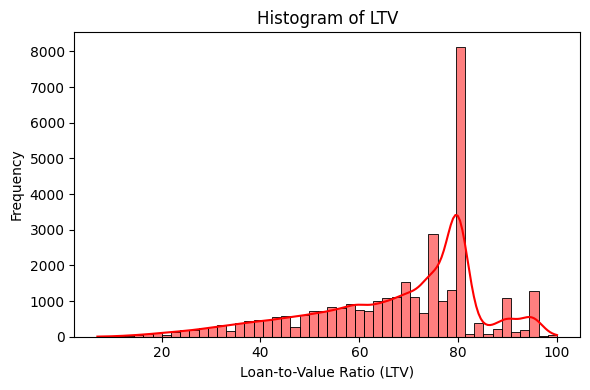

In [8]:
#plot
plt.figure(figsize=(6, 4))
sns.histplot(data1["LTV"], bins=50, kde=True, color='red')
plt.xlabel("Loan-to-Value Ratio (LTV)")
plt.ylabel("Frequency")
plt.title("Histogram of LTV")
plt.tight_layout()
plt.show()

The graph of Loan-to-Value Ratio (LTV) reveals a right-skewed distribution, with a sharp spike at 80%, indicating that many borrowers make a 20% down payment. This is a common threshold used to avoid mortgage insurance. Most loans fall between 60% and 85% LTV, which suggests that borrowers typically contribute some equity. A smaller number of loans have LTVs above 90%, including some at 100%, which reflects riskier lending scenarios where borrowers put little or no money down. Overall, the data shows that 80% LTV is a key industry standard, balancing borrower affordability with lender risk protection.

The histogram of LTV strongly suggests a relationship with interest rates, especially due to the risk-based pricing model lenders use. While we can’t visually map this directly to the interest rate distribution from the previous histogram, the economic logic and lending standards imply that higher LTVs likely correlate with higher rates.

In conlusion, based on the visual analysis of histograms and economic reasoning, several variables in the dataset appear to show potential correlation with interest rates:
	1.	Loan Term: There is a clear, positive relationship between loan term length and average interest rate. Longer-term loans are consistently associated with higher interest rates, reflecting increased lender risk over time.
	2.	Debt-to-Income Ratio (DTI): While the histogram suggests a wide distribution, borrowers with higher DTI are generally considered riskier, and thus, likely face higher interest rates. However, a more precise relationship would require a scatter plot or regression.
	3.	Loan-to-Value Ratio (LTV): A strong spike at 80%—a critical underwriting threshold—along with the distribution’s shape, indicates that higher LTV ratios may lead to higher interest rates. This aligns with lending practices where lower equity implies higher default risk.
	4.	Unpaid Principal Balance (UPB): The histogram shows a right-skewed distribution with no strong visual indication of a correlation to interest rates. UPB alone may not determine rate levels; its effect is likely moderated by loan term and credit quality.

In summary, Loan Term, DTI, and LTV emerge as the most plausible predictors of interest rates, both visually and based on financial theory. These variables should be prioritized in further analysis through regression.

### 2. Finding Possible Issues Of Multicorlinearty 

Multicollinearity occurs when two or more independent variables in a regression model are highly correlated, meaning they contain overlapping information about the variation in the dependent variable. This can be problematic because it undermines the statistical significance of individual predictors: standard errors inflate, making it difficult to determine which variables truly have meaningful effects. We want to find this issue before we run a regression. 

In [9]:
#correlation matrix 
correlation_matrix = data1[["Credit_Score", "DTI", "UPB_Thousands", "LTV"]].corr()

#show correlation matrix
correlation_matrix.style.background_gradient(cmap = "cool")

,Credit_Score,DTI,UPB_Thousands,LTV
Credit_Score,1.000000,-0.180023,0.033472,-0.119130
DTI,-0.180023,1.000000,0.106848,0.100170
UPB_Thousands,0.033472,0.106848,1.000000,0.069976
LTV,-0.119130,0.100170,0.069976,1.000000


Credit Score vs. DTI (-0.18): weak negative correlation; higher credit scores are slightly associated with lower DTI.

Credit Score vs. UPB (0.03): weak positive correlation; almost no relationship. 

Credit Score vs. LTV (-0.12): weak negative correlation; borrowers with highter credit scores tend slightly higher LTV ratios. 

DTI vs. UPB (0.11): weak postive correlation; large loans are slightly associated with lower DTI ratios. 

DTI vs. LTV (0.1): weak postive correlation; higher DTI ratios tend to have slightly higher LTV ratios. 

UPB vs. LTV (0.07): weak postive coorelation; larger loans tend to have slightly higher LTV values. 

In conclusion the correlation vlaues are all below 0.2, which shows that multicollinearity is not a signficant factor. 

### 3. Running OLS Regression

Ordinary Least Squares (OLS) regression is a fundamental statistical method used to estimate the relationship between one dependent variable and one or more independent (explanatory) variables. The goal of OLS is to find the best-fitting line—or more generally, a hyperplane in multiple dimensions—that minimizes the sum of the squared differences (errors) between the observed values and the values predicted by the model.

In [10]:
# running ols regression
model_1 = sm.ols("Interest_Rate ~ Credit_Score + DTI + UPB_Thousands + LTV", data=data1).fit(cov_type ="HC1")
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Interest_Rate   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     1047.
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        18:51:28   Log-Likelihood:                -27289.
No. Observations:               34577   AIC:                         5.459e+04
Df Residuals:                   34572   BIC:                         5.463e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.1846      0.062     83.482      0.000       5.063       5.306
Credit_Score     -0.0020   7.58e-05    -26.790      0.000      -0.002      -0.002
DTI               0.0075      0.000     25.563      0.000       0.007       0.008
UPB_Thousands    -0.0001   2.28e-05     -5.517      0.000      -0.000   -8.12e-05
LTV               0.0074      0.000     43.833      0.000       0.007       0.008
==============================================================================
Omnibus:                     1005.615   Durbin-Watson:                   0.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              574.307
Skew:                          -0.154   Prob(JB):                    1.95e-125
Kurtosis:                       2.449   Cond. No.                     1.67e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Holding all independant variables zero, the predcited rate is at 5.1846. 

All predictor varibales have p-values of 0.000 meaning theyare highly statistcally signficant at the 5% level, indicating each variables has a meaningful effect on interest rate. 

Holding all other variables constant, a 1-point increase in Credit Score would decrease interest rate by 0.002. 

Holding all other variables constant, a 1 percentage point increase in DTI leads to a 0.0075 increase in interest rate. 

Holding all other variables constant, a  $1,000 increase in UPB is associated with a 0.0001 decrease in the interest rate.

Holding all other variables constant, a 1 percentage point increase in LTV leads to a 0.0074 percentage point increase in the interest rate.

From the adjusted R-squared, only about 11% of the variance in interest rates is explained by the model. This suggests that while the included variables are significant, many other factors (e.g., loan type, market rates, term structure) also influence interest rates. 

The regression confirms that credit risk variables—Credit Score, DTI, LTV—are statistically and economically significant predictors of mortgage interest rates. Higher DTI and LTV increase rates, while better credit scores reduce them. UPB has a very small effect. Despite the low R-squared, the model reveals important directional relationships and is statistically sound, though additional variables would be needed to better explain rate variability. 

Since the R-squared value is low, we can try to use different regression method to find a better model. 


### 4. Testing If All Regressors Are Relevant Using the F-Statistics 

In [11]:
# f-test
hypotheses = '(Credit_Score = 0), (DTI = 0), (UPB_Thousands = 0), (LTV = 0)'
f_test_robust = model_1.f_test(hypotheses)
print(f_test_robust)

<F test: F=1046.878418430398, p=0.0, df_denom=3.46e+04, df_num=4>


Null Hypothesis: βDTI = βUPB = βLTV = 0

Alternate Hypothesis: Atleast one  of βDTI, βUPB, βLTV ≠ 0

(signifcance level at 5%)

The F-statistic is exteremly high at 1047 which indicates that the model eplains signficant variation in interest rates. 

The p value is 0.0, at 5% signficance; we reject the null hypothesis. 

At least one of the predictors (DTI, UPB, or LTV) has a significant effect on Interest Rate and is not zero. 
 

### 5. Finding a Possible Logarithmic Relationship

In [12]:
# logarithmic regression
data1 = data1.copy()
data1["log_Credit_Score"] = np.log(data1["Credit_Score"])
data1["log_UPB"] = np.log(data1["UPB"])

model_2 = sm.ols("Interest_Rate ~ log_Credit_Score + DTI + log_UPB + LTV", data=data1).fit(cov_type ="HC1")
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Interest_Rate   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     1084.
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        18:51:28   Log-Likelihood:                -27217.
No. Observations:               34577   AIC:                         5.444e+04
Df Residuals:                   34572   BIC:                         5.449e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           14.1478      0.376     37.602      0.000      13.410      14.885
log_Credit_Score    -1.4789      0.056    -26.299      0.000      -1.589      -1.369
DTI                  0.0078      0.000     26.522      0.000       0.007       0.008
log_UPB             -0.0618      0.005    -12.398      0.000      -0.072      -0.052
LTV                  0.0076      0.000     44.963      0.000       0.007       0.008
==============================================================================
Omnibus:                     1055.478   Durbin-Watson:                   0.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              609.210
Skew:                          -0.169   Prob(JB):                    5.15e-133
Kurtosis:                       2.444   Cond. No.                     9.92e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 9.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Holding all independant variables zero, the predcited rate is at 14.14. 

All predictor varibales have p-values of 0.000 meaning theyare highly statistcally signficant at the 5% level, indicating each variables has a meaningful effect on interest rate. 

Holding all other variables constant, a 1% increase in Credit Score leads to a 1.48 percentage point decrease in itnerest rate 

Holding all other variables constant, a 1 percentage point increase in DTI leads to a 0.0078 percentage point increase in the Interest Rate.

Holding all other variables constant, a 1% increase in UPB leads to a 0.0618 percentage point decrease in the Interest Rate.

Holding all other variables constant, a 1 percentage point increase in LTV leads to a 0.0076 percentage point increase in the Interest Rate.

The new model increase both R-Squared and Adjusted R-Square, which shows it expalins a bit more of the variation in interest rates. It is a better fit. 

The new model also has a higher F-stastics, indicating stronger overall model signficance.

Moreover, the model can be better interpreted as it shows how percentage changes in credit score and UPB changes percentage point changes in interest rates. 

Thus, the log-transformed model is preferred compared to OLS linear model.We see a logarithmic relationship.

### 6. Interest Rate Based On States (Entity Effect)

In [13]:
# adding dummy variables
model_3 = sm.ols("Interest_Rate ~ log_Credit_Score + DTI + log_UPB + LTV + State", data=data1).fit(cov_type ="HC1")
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Interest_Rate   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     111.7
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        18:51:29   Log-Likelihood:                -26526.
No. Observations:               34577   AIC:                         5.317e+04
Df Residuals:                   34520   BIC:                         5.365e+04
Df Model:                          56                                         
Covariance Type:                  HC1                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           14.8023      0.378     39.133      0.000      14.061      15.544
State[T.AL]          0.1328      0.067      1.973      0.048       0.001       0.265
State[T.AR]         -0.0006      0.071     -0.009      0.993      -0.140       0.139
State[T.AZ]          0.3004      0.063      4.746      0.000       0.176       0.425
State[T.CA]          0.3110      0.060      5.186      0.000       0.193       0.428
State[T.CO]          0.2305      0.062      3.729      0.000       0.109       0.352
State[T.CT]          0.1281      0.064      1.985      0.047       0.002       0.254
State[T.DC]          0.4395      0.076      5.803      0.000       0.291       0.588
State[T.DE]          0.1938      0.076      2.534      0.011       0.044       0.344
State[T.FL]          0.2246      0.062      3.650      0.000       0.104       0.345
State[T.GA]          0.0890      0.063      1.421      0.155      -0.034       0.212
State[T.GU]          0.0910      0.203      0.447      0.655      -0.308       0.490
State[T.HI]          0.2716      0.072      3.792      0.000       0.131       0.412
State[T.IA]         -0.1154      0.066     -1.758      0.079      -0.244       0.013
State[T.ID]          0.1875      0.070      2.660      0.008       0.049       0.326
State[T.IL]          0.0544      0.061      0.893      0.372      -0.065       0.174
State[T.IN]         -0.0050      0.062     -0.080      0.936      -0.127       0.117
State[T.KS]         -0.0145      0.066     -0.221      0.825      -0.143       0.114
State[T.KY]          0.0553      0.063      0.873      0.383      -0.069       0.179
State[T.LA]          0.2076      0.066      3.146      0.002       0.078       0.337
State[T.MA]          0.1275      0.061      2.087      0.037       0.008       0.247
State[T.MD]          0.2203      0.062      3.533      0.000       0.098       0.343
State[T.ME]          0.1014      0.073      1.390      0.165      -0.042       0.244
State[T.MI]          0.0121      0.063      0.194      0.846      -0.111       0.135
State[T.MN]          0.0297      0.062      0.479      0.632      -0.092       0.151
State[T.MO]          0.0302      0.062      0.484      0.628      -0.092       0.153
State[T.MS]          0.2348      0.082      2.851      0.004       0.073       0.396
State[T.MT]          0.0511      0.073      0.701      0.483      -0.092       0.194
State[T.NC]          0.1196      0.062      1.944      0.052      -0.001       0.240
State[T.ND]         -0.0231      0.081     -0.284      0.777      -0.183       0.136
State[T.NE]         -0.0610      0.068     -0.893      0.372      -0.195       0.073
State[T.NH]          0.1113      0.068      1.628      0.103      -0.023       0.245
State[T.NJ]          0.1657      0.062      2.692      0.007       0.045       0.286
State[T.NM]          0.

To avoid the dummy variable trap, we drop one of the dummary variables, Alaska. 

Taking two States as Examples for interpretation:

State[T.NV] (0.3446, p = 0.000)
With statiscal signficance, loans in Nevada have interest rates that are 0.3446 percentage points higher than Alaska.  


State[T.TX] (-0.1154, p = 0.079)
At the 90% signficance level (alpha = 10%), loans in Texas have interest rates that are -.1154 percentage point slower than Alaska. 

log_Credit_Score (-1.4901): The coefficient remains nearly unchanged, meaning that state-level differences do not significantly impact the relationship between credit score and interest rates.

DTI (0.0066): The effect of DTI on interest rates decreases slightly, likely because some state-level factors may already explain borrower risk.

log_UPB (-0.1250): The effect becomes more negative, meaning that after accounting for state differences, larger loan amounts are associated with even lower interest rates.

LTV (0.0088): The effect increases slightly, possibly because LTV may capture risk factors that vary across states. 


To improve the model, we adjust for the entity effect. These dummy variables control for entity-specific characteristics that do not change over time and might otherwise bias your coefficient estimates.


R-Squared increased from 0.113 to 0.148, indicating that the model explains more variation in interest rates after including state variables.

The F-statistic increased, meaning the overall model is more statistically significant.
	
Thus, the goodness of the model improved. The location of where the loan is made is signficant in determining interest rates. 

### 7. Machine Learning

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
features = ['log_Credit_Score', 'DTI', 'log_UPB', 'LTV'] 
X = data1[features]
y = data1['Interest_Rate']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVR needs feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print("Decision Tree R2:", r2_score(y_test, y_pred_dt))

Decision Tree RMSE: 0.7513954677813232
Decision Tree R2: -0.7576783815684185


In [16]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, None],           # Control tree depth
    'min_samples_split': [2, 5, 10],         # Min samples to split a node
    'min_samples_leaf': [1, 2, 4]            # Min samples in a leaf
}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_

y_pred_dt = best_dt.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print("Decision Tree R2:", r2_score(y_test, y_pred_dt))

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Decision Tree RMSE: 0.5320531818725436
Decision Tree R2: 0.11872315720857363


In [17]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)

print("SVR RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_svr)))
print("SVR R2:", r2_score(y_test, y_pred_svr))

SVR RMSE: 0.5312642048833389
SVR R2: 0.12133489468640923


In [18]:
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_svr = grid_search.best_estimator_

y_pred_svr = best_svr.predict(X_test_scaled)
print("Best Parameters:", grid_search.best_params_)
print("SVR RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_svr)))
print("SVR R2:", r2_score(y_test, y_pred_svr))

Best Parameters: {'C': 0.1, 'epsilon': 0.2}
SVR RMSE: 0.5288895571538961
SVR R2: 0.1291722641478087


In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

Random Forest RMSE: 0.5518054675489256
Random Forest R2: 0.052074366376190784


In [20]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

/opt/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest RMSE: 0.5268124369187444
Random Forest R2: 0.1359988765799125


Findings:

The ML models used here (Decision Trees, SVR and Random Forest) perform slightly better than the OLS regression after parameters tuned by Grid Search. 

There are several possible reasons for this results:
1. While the OLS regression results showed that the selected predictors were statistically significant, they do not capture much of the overall variation in interest rates (with a low R^2 of 0.11).

2. More features might be needed to boost the performance, such as loan type, term, geographic location, or broader economic indicators. The models need rich context that help improve predictions.

3. The target variable, interest rate, spans a very narrow range (approximately 3.9% to 4.8% as shown in the box plot), making it challenging for any model to explain a large portion of its variance.



### Conclusion

This project analyzed the determinants of mortgage interest rates using a rich dataset from Freddie Mac. Through a series of regression models, including fixed effects and log-transformed specifications, we examined how borrower characteristics and loan attributes influence the pricing of mortgage loans.

The findings reveal that key financial indicators such as Debt-to-Income Ratio (DTI), Loan-to-Value Ratio (LTV), and Unpaid Principal Balance (UPB) are all statistically significant predictors of interest rates. As expected, higher DTI and LTV ratios are associated with higher interest rates, reflecting greater risk to lenders. Conversely, higher credit scores are linked to lower interest rates, consistent with risk-based pricing practices. The log-transformed models improved interpretability and slightly enhanced model fit, suggesting some nonlinear relationships between borrower traits and rate setting.

Incorporating state fixed effects highlighted regional disparities in interest rate levels that persist even after controlling for borrower-level variables. These differences may reflect variations in state-level policies, lending practices, or economic conditions.

Overall, the analysis supports the conclusion that borrower risk characteristics play a central role in mortgage pricing. While the model explains a modest portion of the total variation in interest rates, it provides meaningful insight into how lenders assess risk and adjust rates accordingly. Future extensions could include additional variables (e.g., loan purpose, lender identity, or time fixed effects) or panel data methods to better capture temporal trends in mortgage markets.